<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
    
## Специализация "Машинное обучение и анализ данных"
</center>
<center>Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий

# <center>  Capstone проект №1. Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 3. Визуальный анализ данных и построение признаков

На 3 неделе мы займемся визуальным анализом данных и построением признаков. Сначала мы вместе построим и проанализируем несколько признаков, потом Вы сможете сами придумать и описать различные признаки. Задание имеет вид Peer-Review, так что творчество здесь активно приветствуется. Если задействуете IPython-виджеты, библиотеку Plotly, анимации и прочий интерактив, всем от этого будет только лучше.

**План 3 недели:**
 - Часть 1. Построение признаков
 - Часть 2. Визуальный анализ данных
 - Часть 3. Дальнейшее построение признаков
 - Часть 4. Проверка построенных признаков

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Поиск структуры в данных":**
   - [Задача визуализации](https://www.coursera.org/learn/unsupervised-learning/lecture/hlvlT/zadacha-vizualizatsii)
   - [Визуализация данных в sklearn](https://www.coursera.org/learn/unsupervised-learning/lecture/ityMo/vizualizatsiia-dannykh-v-sklearn)
   
**Также в задании будет использоваться библиотека Seaborn (ее можно дополнительно установить командой *pip install seaborn*), будет полезно обращаться к документациям [Matplotlib](http://matplotlib.org/users/) и [Seaborn](http://seaborn.pydata.org/), а также к примерам визуализации, описанным на StackOverflow.**



## Часть 1. Построение признаков

In [92]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
from glob import glob
import os
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
pd.set_option('display.max.columns', 25)
import pickle
#pip install seaborn
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt

from itertools import tee

In [93]:
plt.rcParams['figure.figsize'] = (13, 8)

In [94]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = ('capstone_user_identification')

**Создайте на основе функций *prepare_train_set* и *prepare_sparse_train_set_window*  новую – *prepare_train_set_with_fe*, (от "feature engineering"), создайте следующие признаки:**
- `session_timespan` – продолжительность сессии (разница между максимальным и минимальным временем посещения сайтов в сессии, в секундах)
- `#unique_sites` – число уникальных сайтов в сессии 
- `start_hour` – час начала сессии (то есть час в записи минимального timestamp среди десяти)
- `day_of_week` – день недели (то есть день недели в записи минимального timestamp среди десяти)

Функция должна возвращать новый DataFrame (как возвращала функция *prepare_train_set*), только признаков должно быть на 4 больше. Порядок, в котором добавляются признаки: *site1*, ... *site10*, *session_timespan*, *#unique_sites*, *start_hour*, *day_of_week* и *user_id* (это видно и чуть ниже по тому, как функция вызывается).

In [95]:
def session_string(session_it, session_length):
    '''
    Генератор
    Принимает итератор по файлу
    Возвращает строку
    '''
    try:
        for i in range(session_length):
            yield next(session_it)
    except StopIteration:
        return

In [186]:
def user_features(file, session_length, window_size, site_map, user_id):
    '''
    Генератор
    Создаёт массив признаков пользователя
    session_length: длина сессии
    window_size: длина шага
    site_map: словарь сайтов в формате 'site': site_id
    user_id: целевой признак
    '''
    windows_it = iter(file) # итератор по всему файлу (по строкам)
    i = 0

    while True:
        try:
            if i % window_size == 0: # начинаем писать сессию
                # разделяем итератор на два; новый итератор только по сессии (как вложенный цикл)
                windows_it, session_it = tee(windows_it)
                session = list(session_string(session_it, session_length))
                if session: # чтобы не возвращать в конце пустую строку
                    # обрабатываем сайты
                    sites_fact = list(map(lambda x: x.split(',')[1].strip(), session))
                    sites_ids = np.array([site_map[site] for site in sites_fact])
                    # список сайтов
                    sites = np.zeros(session_length)
                    sites[:len(sites_fact)] = sites_ids
                    # число уникальных сайтов
                    n_unique_sites = np.unique(sites_ids).size
                    
                    # обрабатываем timestamp'ы
                    times_fact = list(map(lambda x: pd.to_datetime(x.split(',')[0].strip()), session))
                    timediffs = np.array([(times_fact[i+1] - times_fact[i]).seconds for i in range(len(times_fact) - 1)])
                    # список разниц времён - по сути время посещения каждого сайта (кроме последнего)
                    times = np.zeros(session_length - 1)
                    times[:len(timediffs)] = timediffs
                    # длина сессии (минус время посещения последнего сайта)
                    session_timespan = (times_fact[-1] - times_fact[0]).seconds
                    # час начала сессии
                    start_hour = times_fact[0].hour
                    # день недели начала сессии
                    start_day_of_week = times_fact[0].weekday()
                    
                    yield np.concatenate((sites, times, [session_timespan], [n_unique_sites], 
                                          [start_hour], [start_day_of_week], [user_id]))
        except StopIteration:
            return

        try:
            next(windows_it)
            i += 1
        except StopIteration:
            return

In [97]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names, session_length=10, window_size=10):
    '''
    Преобразует набор файлов в датасет: строка - сессия
    '''
    
    site_dict = []
    train_set, user_ids = [], []

    # скачиваем словарь сайтов    
    with open(site_freq_path, 'rb') as f:
        site_dict.append(pickle.load(f))
    site_map = {k: v[0] for k, v in site_dict[0].items()}


    for file_ in tqdm(glob(os.path.join(path_to_csv_files, '*'))): # '*'
        user_id = int(os.path.splitext(os.path.basename(file_))[0][-4:]) # берём user id из имени файла
        with open(file_) as f:
            f.readline() # пропускаем первую строку
            # итерируемся по сессиям одного пользователя
            for session in user_features(f, session_length, window_size, site_map, user_id):
                train_set.append(session)
                user_ids.append(user_id)

    return pd.DataFrame(train_set, dtype='int', columns=feature_names)

**Проверим функцию на игрушечном примере.**

In [187]:
feature_names = ['site' + str(i) for i in range(1,11)] + \
                ['time_diff' + str(j) for j in range(1,10)] + \
                ['session_timespan', '#unique_sites', 'start_hour', 
                 'day_of_week', 'target']
train_data_toy  = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, 
                                                         '3users'), 
                  site_freq_path=os.path.join(PATH_TO_DATA, 
                                              'site_freq_3users.pkl'),
                  feature_names=feature_names, session_length=10)

  0%|          | 0/3 [00:00<?, ?it/s]

In [188]:
train_data_toy

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,2,3,2,4,5,6,7,8,287,1184,6278,186,2,1,2,3,55,7998,8,9,4,1
1,1,4,4,4,0,0,0,0,0,0,2,3,55,0,0,0,0,0,0,60,2,12,4,1
2,1,2,9,9,2,0,0,0,0,0,287,1184,6278,186,0,0,0,0,0,7935,3,9,4,2
3,10,4,2,4,2,4,4,6,11,10,287,1184,6278,186,2,1,2,3,55,7998,5,9,4,3
4,10,4,2,0,0,0,0,0,0,0,287,1184,0,0,0,0,0,0,0,1471,3,12,4,3


**Примените функцию *prepare_train_set_with_fe* к данным по 10 пользователям, укажите *session_length*=10.**

In [100]:
%%time
train_data_10users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '10users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

Wall time: 14.1 s


In [101]:
train_data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9,session_timespan,#unique_sites,start_hour,day_of_week,target
0,1,2,3,4,3,3,4,3,5,3,10,0,0,1,20,1,0,1,0,33,5,8,4,31
1,6,7,8,9,3,10,11,12,13,14,1,0,163,105,0,1,3,3,8,284,10,8,4,31
2,14,4,14,14,15,16,6,17,18,14,0,14,1,242,0,0,1,0,0,258,7,8,4,31
3,19,20,19,14,14,14,14,21,22,23,2,1,0,1,25,1,0,0,0,30,6,8,4,31
4,24,14,15,25,26,27,28,29,30,29,1,0,1,1,1,0,1,1,0,6,9,8,4,31


**Примените функцию *prepare_train_set_with_fe* к данным по 150 пользователям, укажите *session_length*=10.**

In [102]:
%%time
train_data_150users = prepare_train_set_with_fe(
    os.path.join(PATH_TO_DATA, '150users'), 
    site_freq_path=os.path.join(PATH_TO_DATA, 'site_freq_150users.pkl'),
    feature_names=feature_names, session_length=10
)

  0%|          | 0/150 [00:00<?, ?it/s]

Wall time: 2min 18s


**Сохраните в pickle-файлы признаки *session_timespan*, *#unique_sites*, *start_hour* и *day_of_week* для 10 и 150 пользователей.**

In [106]:
new_features = ['session_timespan', '#unique_sites', 'start_hour', 'day_of_week']

In [107]:
train_data_10users[new_features]

,session_timespan,#unique_sites,start_hour,day_of_week
0,33,5,8,4
1,284,10,8,4
2,258,7,8,4
3,30,6,8,4
4,6,9,8,4
...,...,...,...,...
14056,27,8,15,2
14057,11,8,15,2
14058,16,6,15,2
14059,242,5,15,2


In [108]:
new_features_10users = train_data_10users[new_features]
new_features_150users = train_data_150users[new_features]

In [109]:
with open(os.path.join(PATH_TO_DATA, 'new_features_10users.pkl'), 'wb') as new_features_10users_pkl:
    pickle.dump(new_features_10users, new_features_10users_pkl)
with open(os.path.join(PATH_TO_DATA, 'new_features_150users.pkl'), 'wb') as new_features_150users_pkl:
    pickle.dump(new_features_150users, new_features_150users_pkl)

## Часть 2. Визуальный анализ данных

**Забавы ради, для потехи дадим пользователям имена и ассоциируем с ними цвета.**

In [110]:
id_name_dict = {128: 'Mary-Kate', 39: 'Ashley', 207: 'Lindsey', 127: 'Naomi', 237: 'Avril',
               33: 'Bob', 50: 'Bill', 31: 'John', 100: 'Dick', 241: 'Ed'}
train_data_10users['target'] = train_data_10users['target'].map(id_name_dict)

In [111]:
color_dic = {'Mary-Kate': 'pink', 'Ashley': 'darkviolet', 'Lindsey':'blueviolet', 
             'Naomi': 'hotpink', 'Avril': 'orchid', 
             'Bob': 'firebrick', 'Bill': 'gold', 'John': 'forestgreen', 
             'Dick': 'slategrey', 'Ed':'brown'}

**1. Постройте гистограмму распределения длины сессии в секундах (*session_timespan*). Ограничьте по *x* значением 200 (иначе слишком тяжелый хвост). Сделайте гистограмму цвета *darkviolet*, подпишите оси по-русски.**

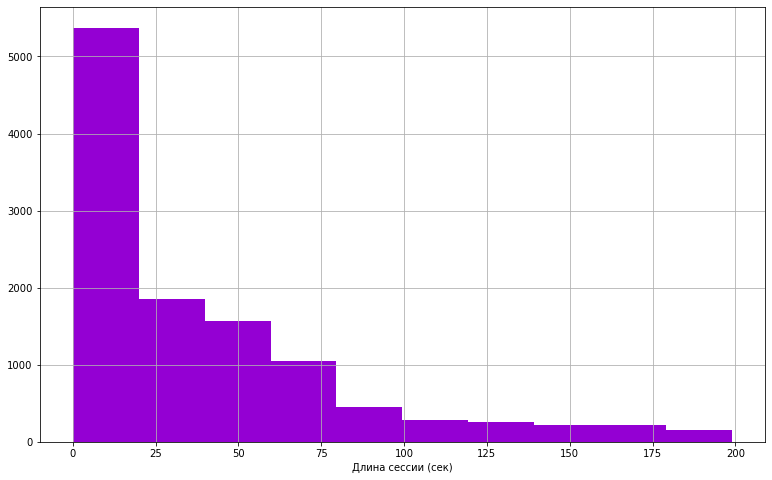

In [112]:
train_data_10users['session_timespan'][train_data_10users.session_timespan < 200].hist(color='darkviolet')
plt.xlabel('Длина сессии (сек)');

**2. Постройте гистограмму распределения числа уникальных сайтов в сессии (*#unique_sites*). Сделайте гистограмму цвета *aqua*, подпишите оси по-русски.**

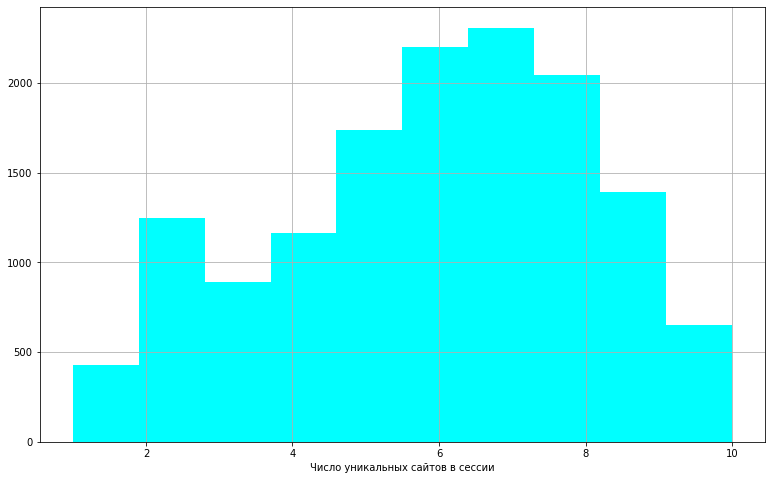

In [113]:
train_data_10users['#unique_sites'].hist(color='aqua')
plt.xlabel('Число уникальных сайтов в сессии');

**3. Постройте гистограммы распределения числа уникальных сайтов в сессии (*#unique_sites*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

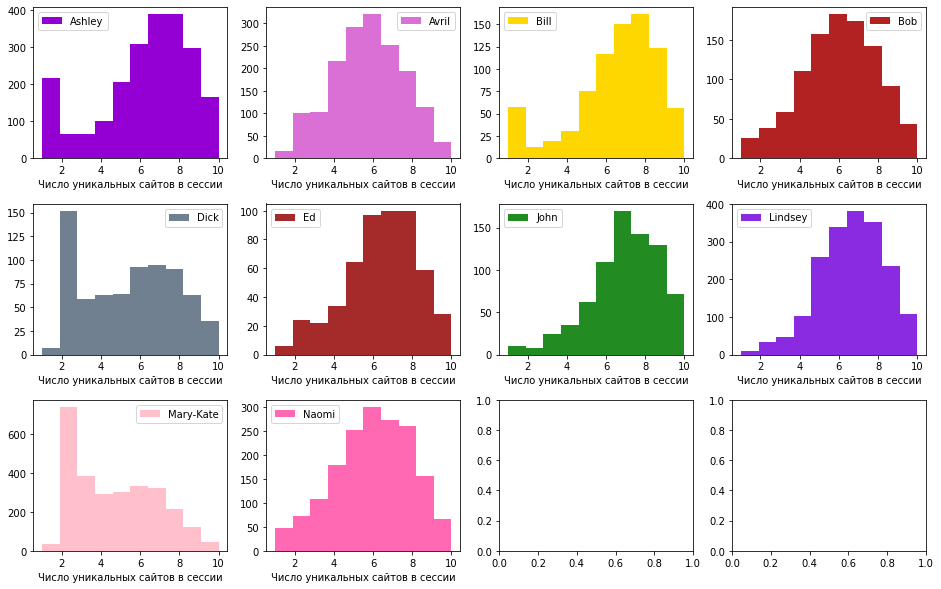

In [170]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['#unique_sites'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Число уникальных сайтов в сессии')

In [174]:
# по-другому можно так
# train_data_10users.hist('#unique_sites', by='target', figsize=(16, 16));

**4. Постройте гистограмму распределения часа начала сессии (*start_hour*). Сделайте гистограмму цвета *darkgreen*, подпишите оси по-русски.**

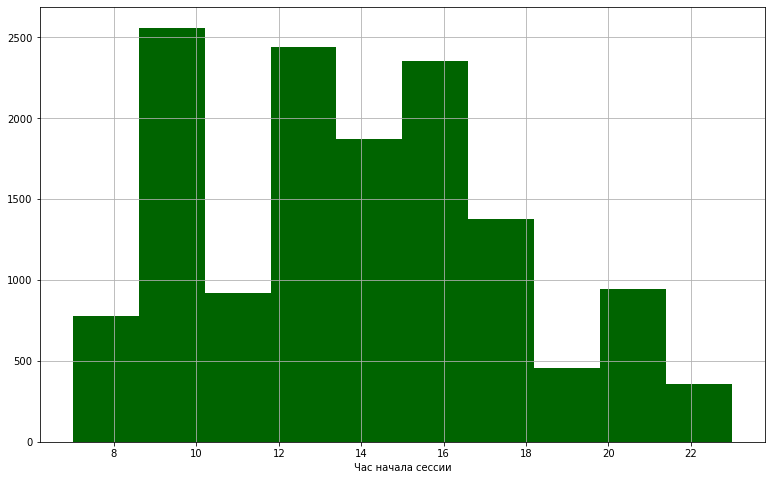

In [173]:
train_data_10users['start_hour'].hist(color='darkgreen')
plt.xlabel('Час начала сессии');

**5. Постройте гистограммы распределения часа начала сессии (*start_hour*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите оси по-русски в каждой из 10 гистограмм.**

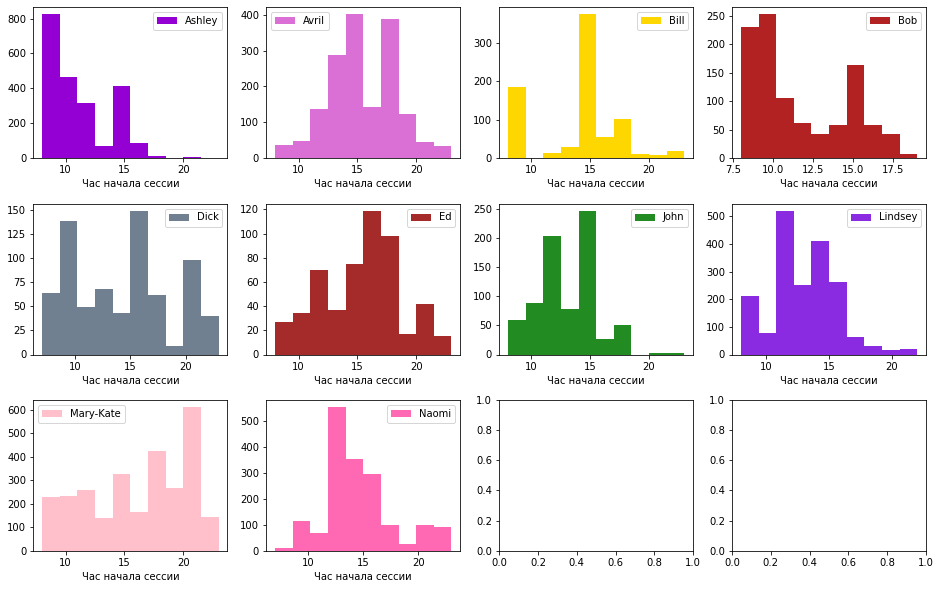

In [175]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['start_hour'], color=color_dic[user], label=user)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('Час начала сессии')

**6. Постройте гистограмму распределения дня недели, в который началась сессия (*day_of_week*). Сделайте гистограмму цвета *sienna*, подпишите оси по-русски.**

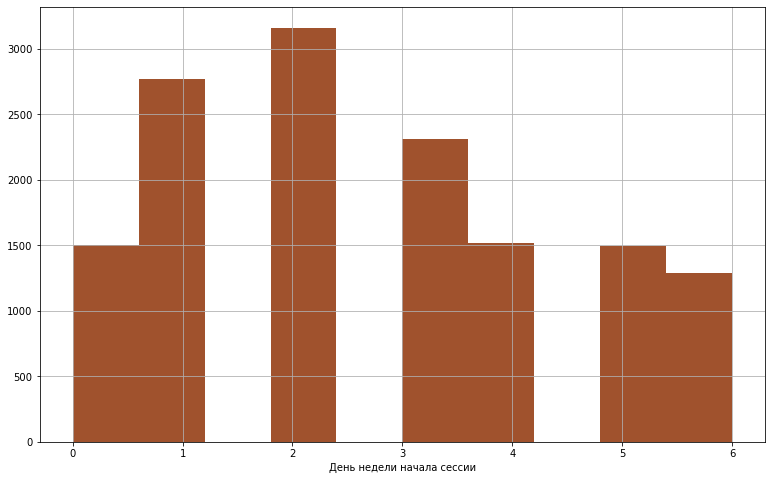

In [179]:
train_data_10users['day_of_week'].hist(color='sienna')
plt.xlabel('День недели начала сессии');

**7. Постройте гистограммы распределения дня недели, в который началась сессия (*day_of_week*) для каждого из 10 пользователей по отдельности. Используйте *subplots*, чтоб разместить все 10 картинок на одной большой. Измените метки по оси *X* на ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'] – метод *set_xticklabels*. Пометьте легендой каждую картинку, на легенде должно быть написано имя пользователя. Для каждого пользователя раскрасьте гистограмму его/ее цветом (*color_dic*). Подпишите по-русски название каждой из 10 гистограмм.**

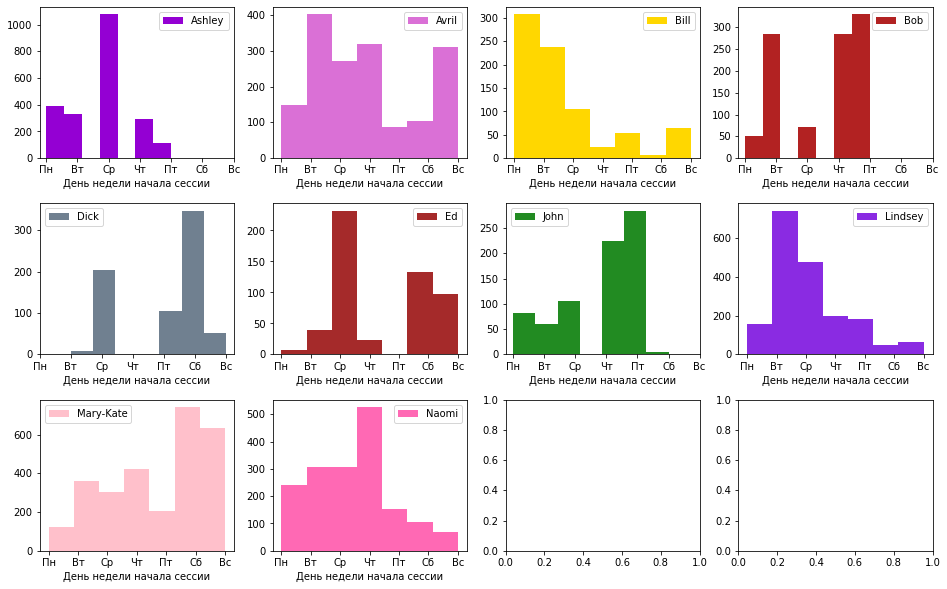

In [195]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10))

# как вариант, можно и по-другому
plt.subplots_adjust(hspace=0.3)
for idx, (user, sub_df) in enumerate(train_data_10users.groupby(by='target')):
    axes[idx//4, idx%4].hist(sub_df['day_of_week'], color=color_dic[user], label=user, bins=7)
    axes[idx//4, idx%4].legend()
    axes[idx//4, idx%4].set_xlabel('День недели начала сессии')
    axes[idx//4, idx%4].set_xticks([0, 1, 2, 3, 4, 5, 6])
    axes[idx//4, idx%4].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])

**8. Сделайте выводы про каждого пользователя по построенным графикам.**

||Ashley|Avril|Bill|Bob|Dick|Ed|John|Lindsey|Mary-Kate|Naomi|
|-|-|-|-|-|-|-|-|-|-|-|
|Посещение уникальных сайтов|-|-|-|-|-|-|-|-|-|-|
|Время начала сессии|-|-|-|-|-|-|-|-|-|-|
|День недели начала сессии|-|-|-|-|-|-|-|-|-|-|

**Загрузите сохраненный ранее в pickle-файл частотный словарь сайтов для 10 пользователей.**

In [ ]:
with open ''' ВАШ КОД ЗДЕСЬ '''

**Определите топ-10 самых посещаемых сайтов (*top10_sites*) и соответствующие кол-ва посещений (*top10_freqs*).**

In [ ]:
top10_freqs = ''' ВАШ КОД ЗДЕСЬ '''
top10_sites = ''' ВАШ КОД ЗДЕСЬ '''

**9. Нарисуйте *seaborn barplot*, показывающий частоты посещений топ-10 сайтов. Сделайте подписи сайтов вертикальными, иначе они сливаются (*xticks*).**

In [ ]:
sns.barplot ''' ВАШ КОД ЗДЕСЬ '''

## Часть 3. Проверка построенных признаков
Эта часть скорее техническая, смысл ее – убедиться, что мы все одинаково создали признаки *session_timespan, #unique_sites, start_hour* и *day_of_week*.

**10. Выведите медианную продолжительность сессии (*session_timespan*) для сессий 10 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**11. Выведите медианный день недели, в который началась сессия, для сессий 10 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**12. Выведите медианный час начала сессии для сессий 150 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**13. Выведите медианное значение числа уникальных сайтов в сессиях 150 пользователей.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

## Часть 4. Дальнейшее построение признаков

Это задание творческое, тут надо придумать, как еще учесть время посещения веб-страниц и прочие признаки. 

На следующей неделе мы будем использовать "мешок" сайтов  для классификации сессий по принадлежности разным пользователям, а эти новые признаки, которые Вы сейчас создадите, потом добавим и посмотрим, улучшается ли модель. Поэтому можно их создать в виде отдельных матриц и сохранить их также отдельно.  

В этой части задания Вы можете построить и визуально исследовать самые разные признаки (ничто фантазию не ограничивает):
- год, месяц и день начала сессии
- час начала сессии (с учетом года, месяца и дня)
- время суток
- среднее время пребывания на сайте, посчитать можно, скажем, для топ-30 популярных сайтов
- индикаторы посещения популярных сайтов (скажем, тоже для топ-30 популярных сайтов)
- частота посещения Facebook
- ...

**Напишите функцию для создания новых признаков и примените ее к исходным данным – каталогам с 10 и 150 файлами. Сделайте это только для набора данных, полученного с параметрами *session_length=10* и *window_size=10*. Сериализуйте полученные матрицы с помощью pickle. Функция может возвращать как только новые признаки, так и старые с новыми. При этом сигнатура функции может быть другой – тут уже свобода выбора.**

In [ ]:
def feature_engineering(path_to_csv_files, features, session_length=10):
    '''
    ВАШ КОД ЗДЕСЬ
    ''' 

In [ ]:
new_features_10users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
new_features_150users = feature_engineering ''' ВАШ КОД ЗДЕСЬ ''' 

**14. Постройте картинки для новых признаков, поисследуйте их, прокомментируйте результаты.**

In [ ]:
''' ВАШ КОД ЗДЕСЬ ''' 

**В конце сохраните в pickle-файлы только те признаки, которые, как Вы предполагаете, помогут идентифицировать пользователя более точно. Это касается и признаков, которые мы вместе создали в начале (*session_timespan, #unique_sites, start_hour, day_of_week*), и Ваших собственных. Можно создать все эти признаки не только для сессий из 10 сайтов, но и для других сочетаний параметров *session_length* и *window_size*.**

In [ ]:
selected_features_10users = ''' ВАШ КОД ЗДЕСЬ ''' 
selected_features_150users = ''' ВАШ КОД ЗДЕСЬ ''' 

In [ ]:
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_10users.pkl'), 'wb') as selected_features_10users_pkl:
    pickle.dump(selected_features_10users, selected_features_10users_pkl, 
                protocol=2)
with open(os.path.join(PATH_TO_DATA, 
                       'selected_features_150users.pkl'), 'wb') as selected_features_150users_pkl:
    pickle.dump(selected_features_150users, selected_features_150users_pkl, 
                protocol=2)

## Критерии оценки работы:
- Верно ли отображена гистограмма session_timespan из п. 1? (max. 3 балла)
- Верно ли отображена гистограмма #unique_sites из п. 2? (max. 3 балла)
- Верно ли отображены гистограммы #unique_sites по каждому пользователю из п. 3? (max. 6 баллов)
- Верно ли отображена гистограмма start_hour из п. 4? (max. 3 балла)
- Верно ли отображены гистограммы start_hour по каждому пользователю из п. 5? (max. 6 баллов)
- Верно ли отображена гистограмма day_of_week из п. 6? (max. 3 балла)
- Верно ли отображены гистограммы day_of_week по каждому пользователю из п. 7? (max. 6 баллов)
- Насколько сделанные выводы в п. 8 соответствуют построенным картинкам? (max. 6 баллов)
- Верно ли отображен barplot для 10 популярных сайтов из п. 9? (max. 6 баллов)
- Правильно ли посчитана медианная продолжительность сессий в п. 10? (max. 3 балла)
- Правильно ли посчитан медианный день недели начала сессии в п. 11? (max. 3 балла)
- Правильно ли посчитан медианный час начала сессии в п. 12? (max. 3 балла)
- Правильно ли посчитано медианное значение числа уникальных сайтов в сессиях 150 пользователей п. 13? (max. 3 балла)
- Есть ли оригинальные построенные признаки и картинки к ним? Оцените также и качество картинок. (max. 8 баллов)

## Пути улучшения
7 неделя посвящена общему описанию проекта (`html`, `ipynb` или `pdf`) и взаимному оцениванию. Что еще можно добавить по 3 части проекта:
- IPython-widgets, интерактив и анимация (стоящие статьи по этому ремеслу – [раз](https://habrahabr.ru/post/308162/) и  [два](https://habrahabr.ru/company/ods/blog/323210/))
- можно попробовать изобразить исходные данные в некотором пространстве, например, Word2Vec, потом выделить главные компоненты или t-SNE  (только пользуйтесь эффективными реализациями типа [Multicore-TSNE](https://github.com/DmitryUlyanov/Multicore-TSNE), не Sklearn) и раскрасить по целевому классу. Но нет гарантий, что получится что-то значимо отличающееся от каши

На следующей неделе мы наконец приступим к обучению моделей классификации. 